<a href="https://colab.research.google.com/github/likarajo/autosales/blob/main/auto_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import required libraries

In [2]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from math import sqrt

## Get Data

FRED Economic Data, [Motor Vehicle Retail Sales: Domestic Auto](https://fred.stlouisfed.org/series/DAUTONSA)

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/likarajo/autosales/main/DAUTONSA.csv')
print(df.dtypes)
df

DATE         object
DAUTONSA    float64
dtype: object


,DATE,DAUTONSA
0,1967-01-01,564.100
1,1967-02-01,509.100
2,1967-03-01,670.400
3,1967-04-01,710.200
4,1967-05-01,744.800
...,...,...
644,2020-09-01,233.855
645,2020-10-01,240.077
646,2020-11-01,210.952
647,2020-12-01,247.360


## Preprocess Data

* Filter and keep only post 2010 data
* Keep only Year and Month in the `DATE` column
* Re-Index to `DATE` COLUMN

In [4]:
df_pp = df[(df['DATE']>='2010-01-01') & (df['DATE']<'2021-01-01')]
df_pp['DATE'] = df_pp['DATE'].apply(lambda x: x[:-3])
df_pp = df_pp.set_index('DATE', drop=True)

df_pp

,DAUTONSA
DATE,
2010-01,240.043
2010-02,272.668
2010-03,375.165
2010-04,343.517
2010-05,389.739
...,...
2020-08,226.712
2020-09,233.855
2020-10,240.077


## Split Data into Train and test sets

Test set = last 6 months data

In [5]:
train = df_pp[:(len(df_pp)-6)]
test = df_pp[(len(df_pp)-6):]

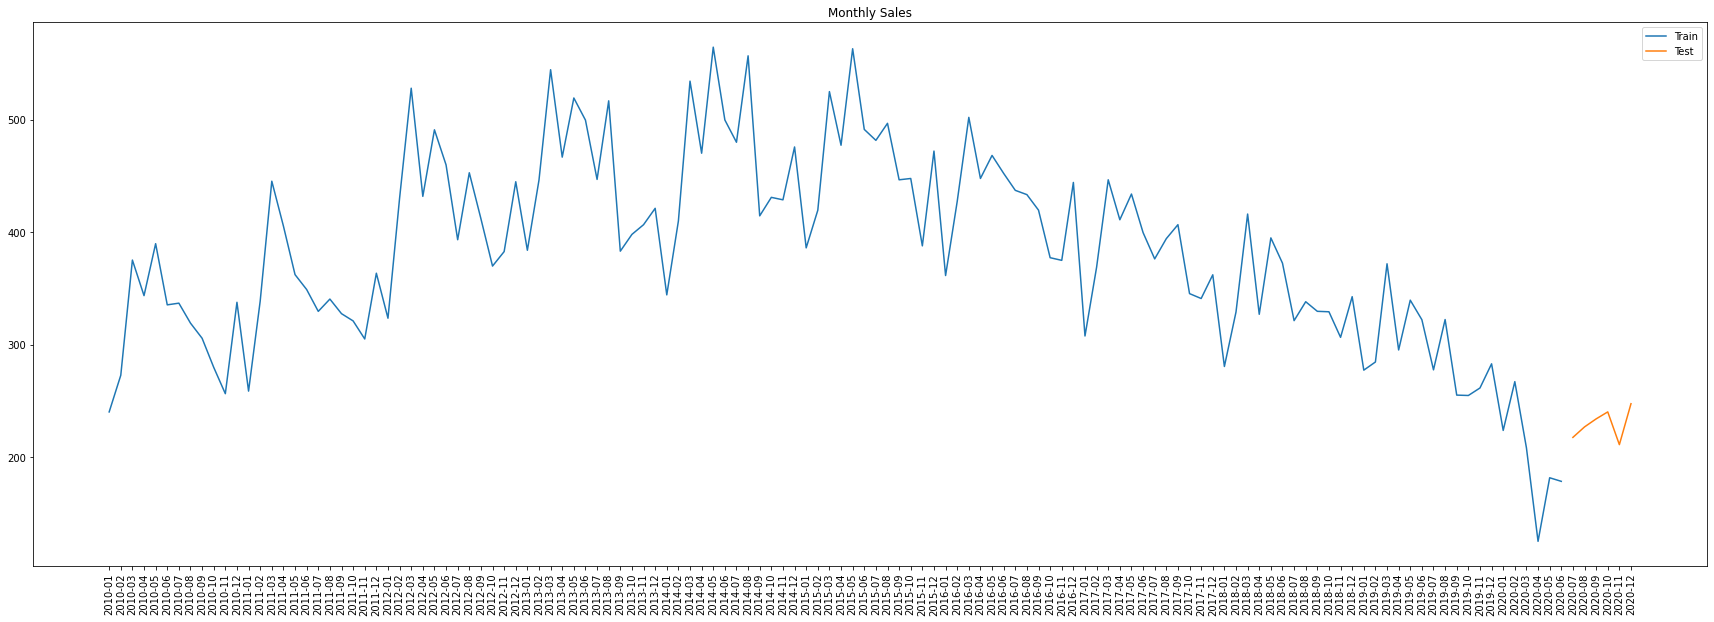

In [6]:
plt.figure(figsize=(30,10))
plt.plot(train.index, train['DAUTONSA'], label='Train')
plt.plot(test.index, test['DAUTONSA'], label='Test')
plt.xticks(rotation = 90)
plt.title('Monthly Sales')
plt.legend(loc='best')
plt.show()

## Time Series Forecasting

In [7]:
pred = test.copy()

### Naive Method

* Assumes that the next expected point is equal to the last observed point.

  `y(t+1) = y(t)`

In [8]:
d = np.asarray(train['DAUTONSA'])
pred['naive'] = d[len(d)-1]

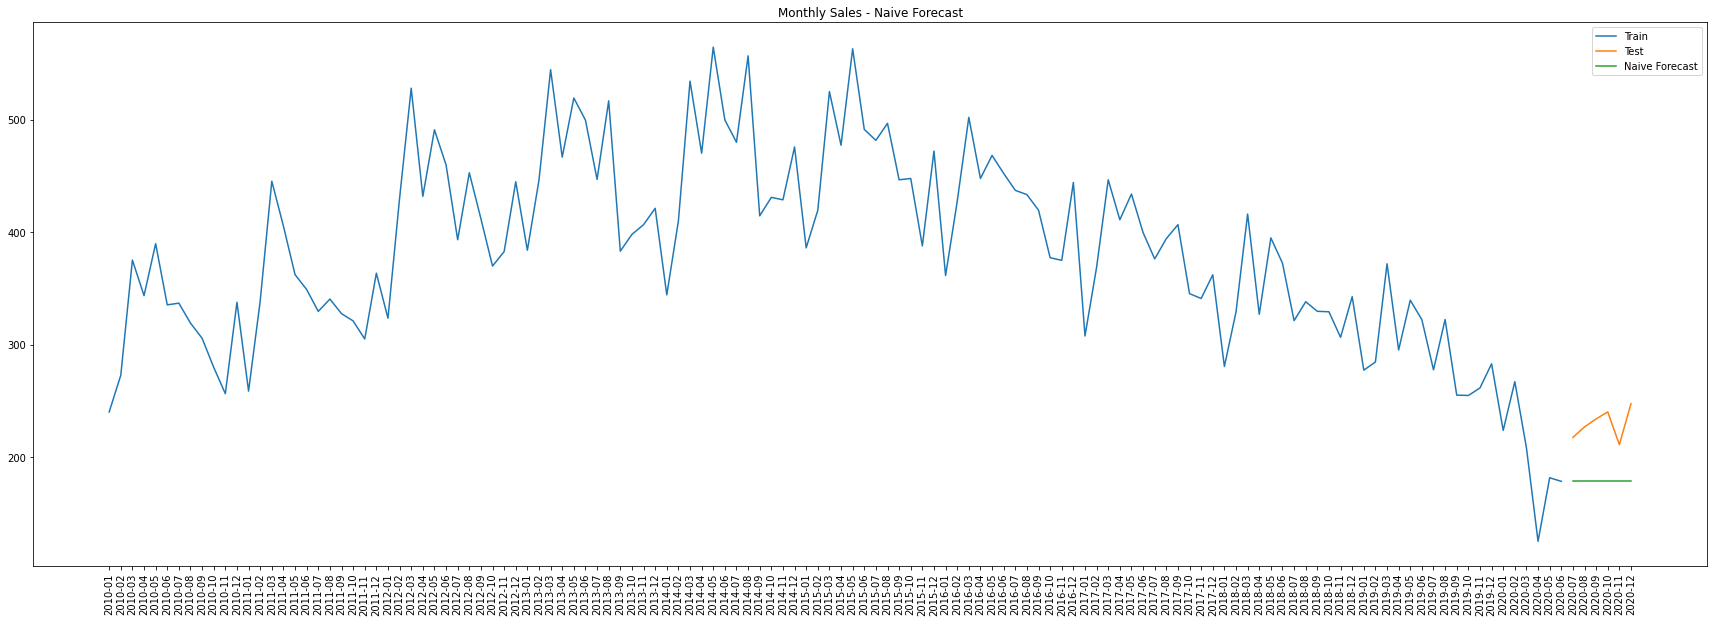

In [9]:
plt.figure(figsize=(30,10))
plt.plot(train.index, train['DAUTONSA'], label='Train')
plt.plot(test.index, test['DAUTONSA'], label='Test')
plt.plot(pred.index, pred['naive'], label='Naive Forecast')
plt.xticks(rotation = 90)
plt.title('Monthly Sales - Naive Forecast')
plt.legend(loc='best')
plt.show()

In [10]:
rmse = sqrt(mean_squared_error(test['DAUTONSA'], pred['naive']))
print(rmse)

52.619632975724954


**Conclusion**: *Naive* method is not suited for datasets with high variability. It is best suited for stable datasets.

### Simple Average

* Assumes that the expected value equals the average of all the previously observed points.

  `y(t+1) = [for(i=1,t) add(y(i))] / t` i.e. the mean



In [11]:
pred['avg'] = train['DAUTONSA'].mean()

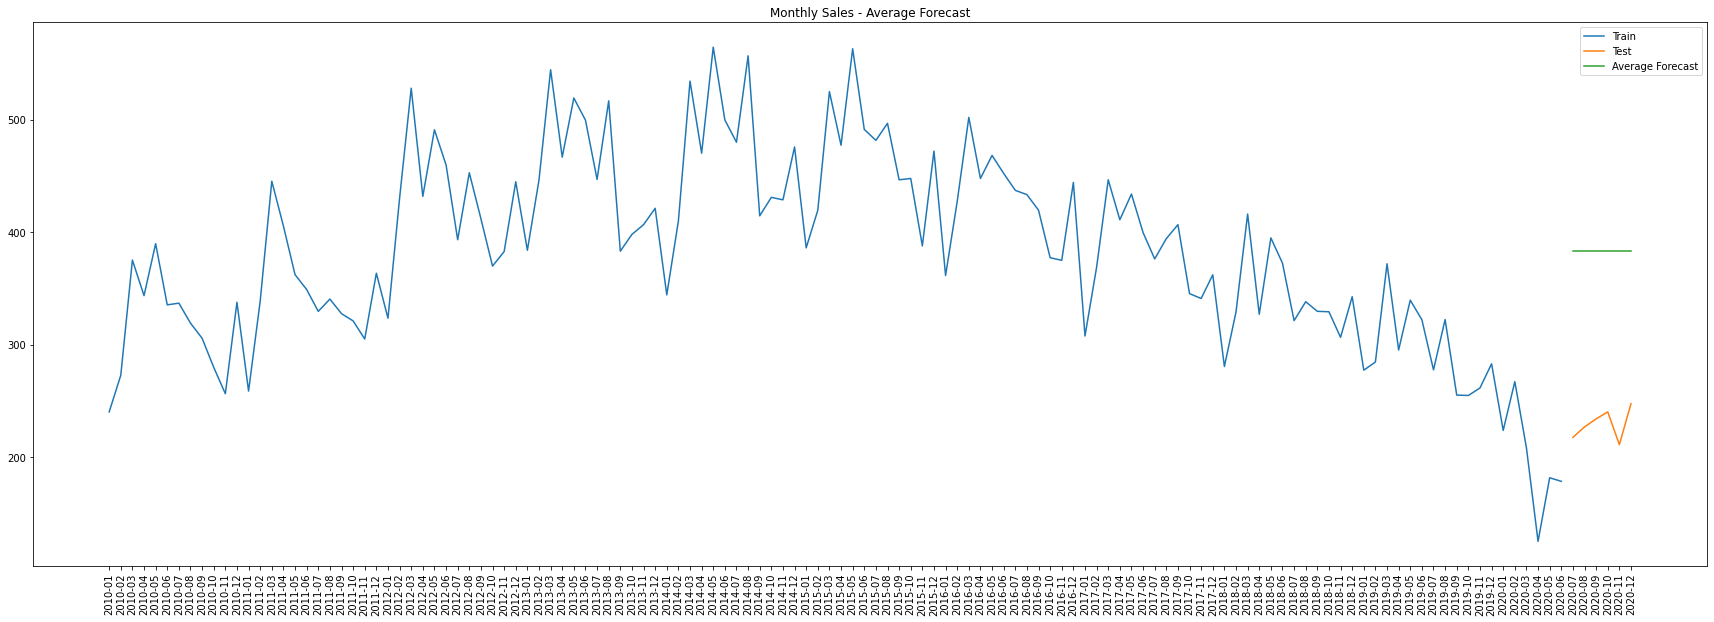

In [12]:
plt.figure(figsize=(30,10))
plt.plot(train.index, train['DAUTONSA'], label='Train')
plt.plot(test.index, test['DAUTONSA'], label='Test')
plt.plot(pred.index, pred['avg'], label='Average Forecast')
plt.xticks(rotation = 90)
plt.title('Monthly Sales - Average Forecast')
plt.legend(loc='best')
plt.show()

In [13]:
rmse = sqrt(mean_squared_error(test['DAUTONSA'], pred['avg']))
print(rmse)

154.04261521815965


**Conclusion**: Average method is not suited for datasets with high variability. It works best when the average at each time period remains constant.

### Moving Average

* Uses window of time period for calculating the average.
* Forecast the next value(s) based on the average of a fixed finite number ‘p’ of the previous values. 

  `y(t+1) = [for(i=t-p,t) add(y(i))] / p`

In [14]:
p = 20
pred['moving_avg'] = train['DAUTONSA'].rolling(p).mean().iloc[-1]

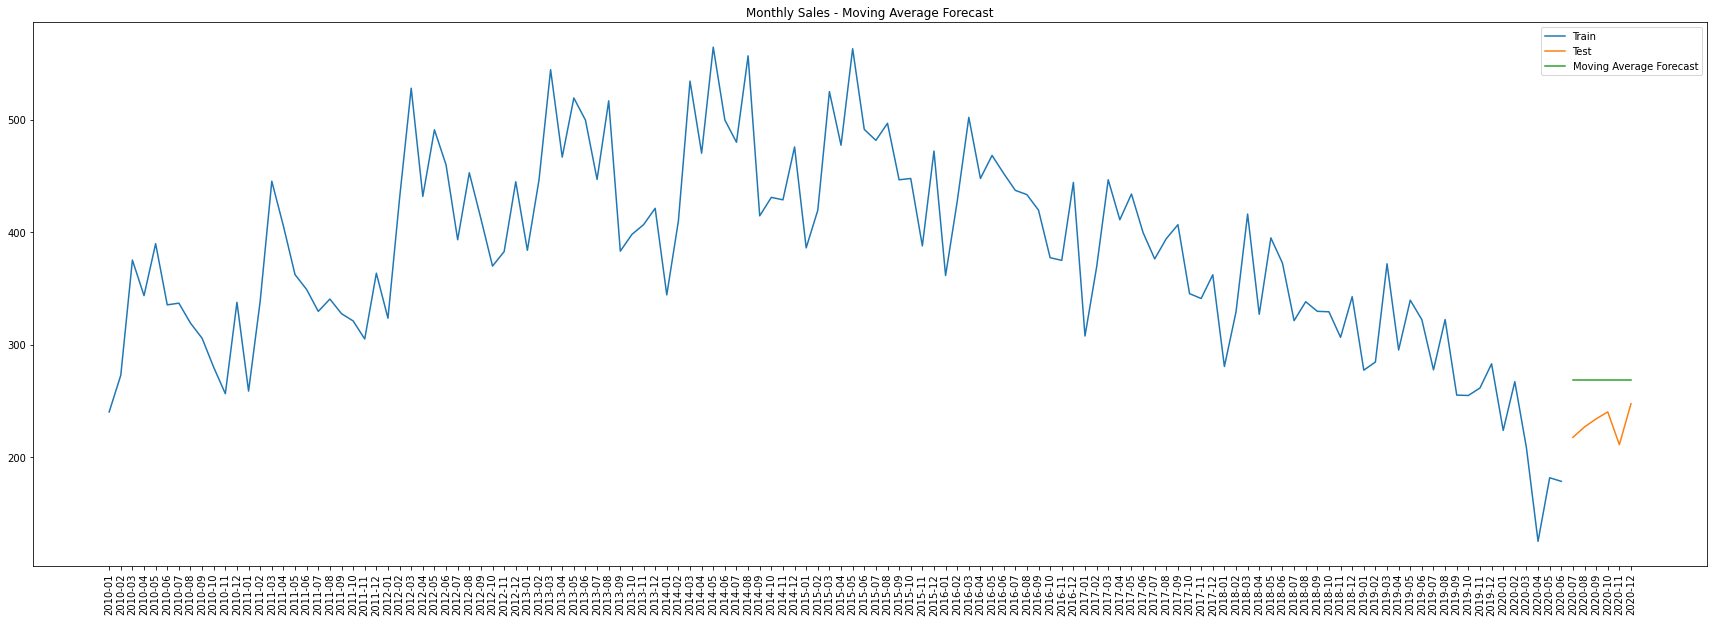

In [15]:
plt.figure(figsize=(30,10))
plt.plot(train.index, train['DAUTONSA'], label='Train')
plt.plot(test.index, test['DAUTONSA'], label='Test')
plt.plot(pred.index, pred['moving_avg'], label='Moving Average Forecast')
plt.xticks(rotation = 90)
plt.title('Monthly Sales - Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [16]:
rmse = sqrt(mean_squared_error(test['DAUTONSA'], pred['moving_avg']))
print(rmse)

41.37842417821761


**Conclusion**: Moving Average method has better result than Simple Average method. However, it is not suited for datasets with high variability. It works best when the average at each time period remains constant.

### Weighted Moving Average

* It is a moving average where within the sliding window values are given different weights, typically so that more recent points matter more

  `y(t+1) = [for(i=t-p,t) add(w(i)*y(i))] / p`



In [29]:
p = 20

weights = np.arange(0, 1 ,1/p)

pred['weighted_moving_avg'] = test['DAUTONSA'].copy()

for t in range(len(pred)):
  wt_sum = 0
  for i in range(p):
    #print(train['DAUTONSA'][t-p+i],'x',weights[i], end=' +\n ')
    wt_sum += train['DAUTONSA'][t-p+i] * weights[i]
  #print()
  pred['weighted_moving_avg'][t] = wt_sum/p

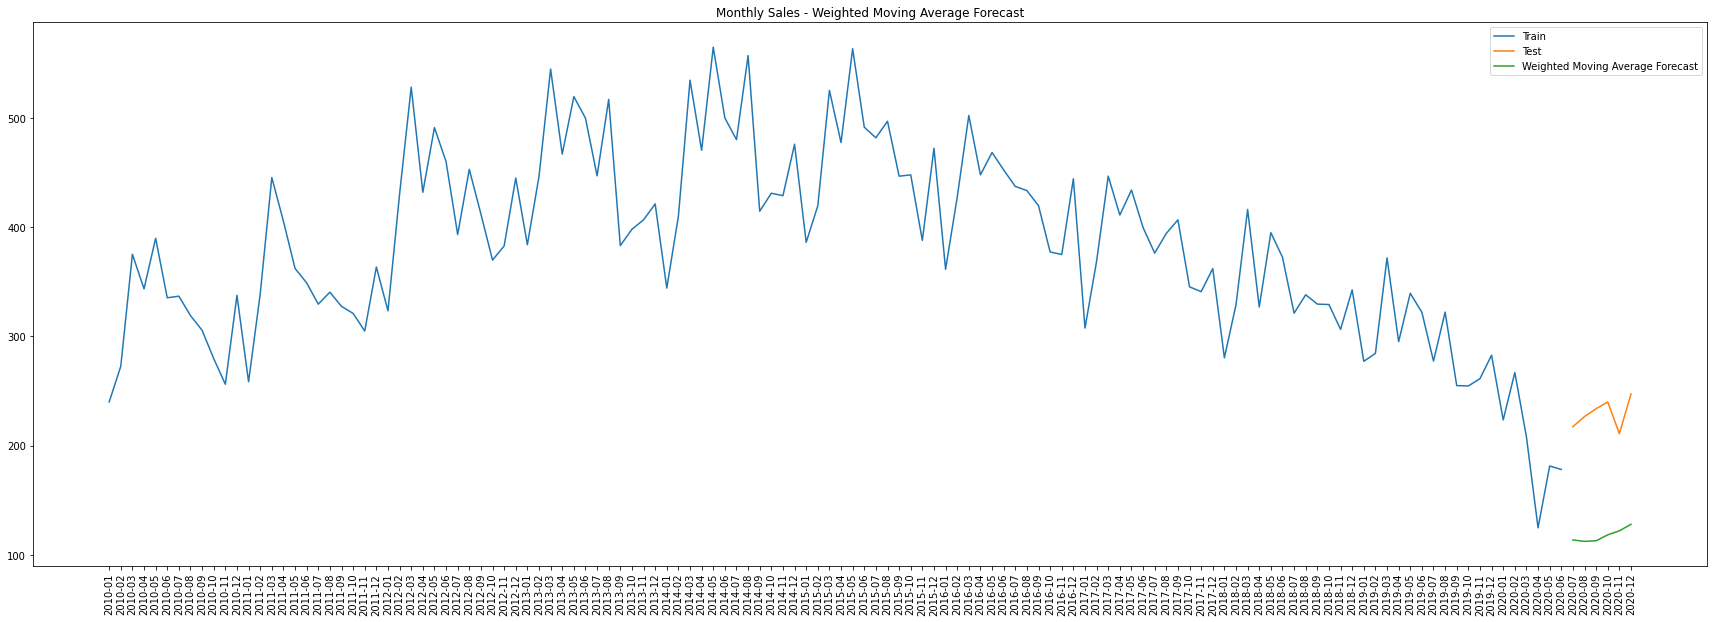

In [30]:
plt.figure(figsize=(30,10))
plt.plot(train.index, train['DAUTONSA'], label='Train')
plt.plot(test.index, test['DAUTONSA'], label='Test')
plt.plot(pred.index, pred['weighted_moving_avg'], label='Weighted Moving Average Forecast')
plt.xticks(rotation = 90)
plt.title('Monthly Sales - Weighted Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [31]:
rmse = sqrt(mean_squared_error(test['DAUTONSA'], pred['weighted_moving_avg']))
print(rmse)

111.96095134248814


**Conclusion**: Weighted Moving Average method is more pragmatic than Moving Average method. However, it is not suited for datasets with high variability.

In [ ]:
pred['weighted_moving_avg'] = train['DAUTONSA'].rolling(p).mean().iloc[-1]

### Simple Exponential Smoothing

In [32]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [35]:
arr_train = np.asarray(train['DAUTONSA'])
model = SimpleExpSmoothing(arr_train)

model = model.fit(smoothing_level=0.6, optimized=False)

pred['ses'] = model.forecast(len(test))

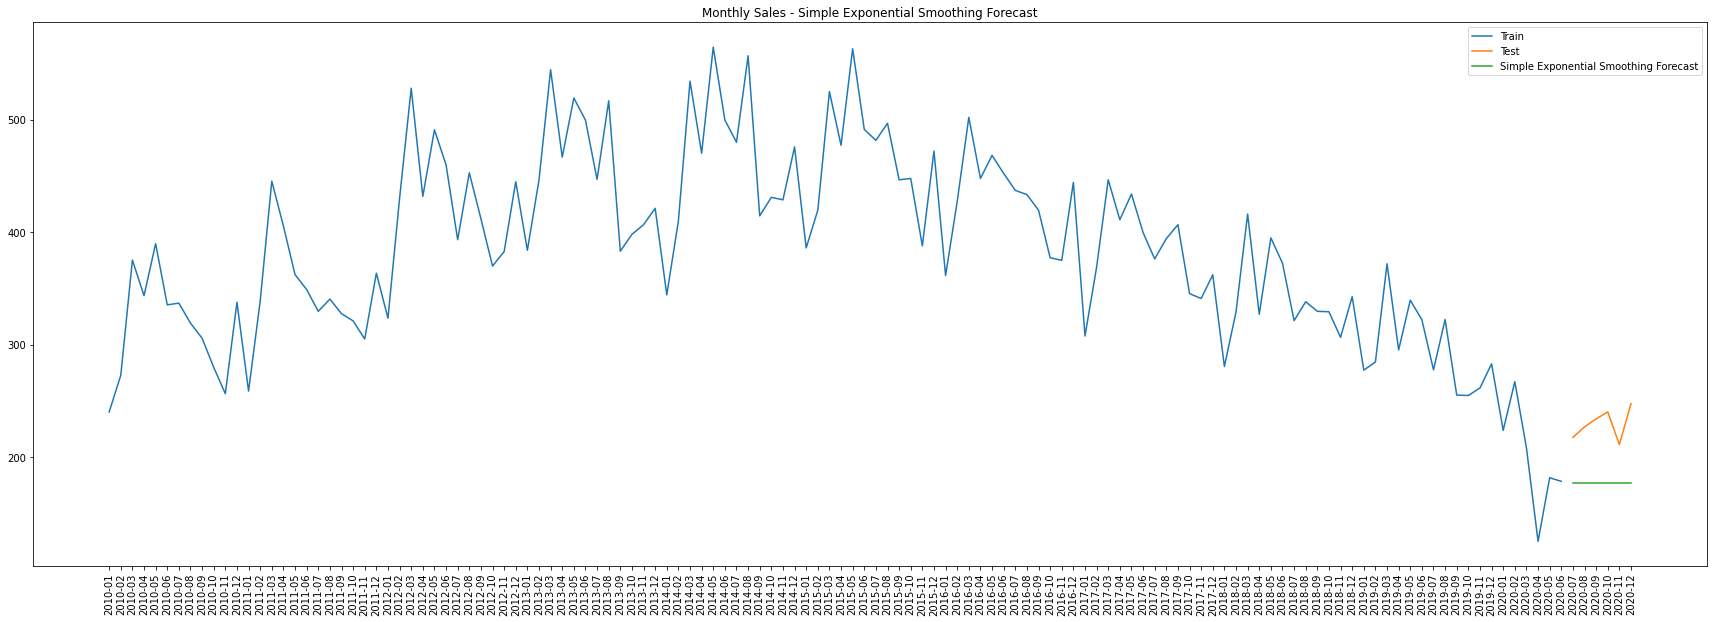

In [36]:
plt.figure(figsize=(30,10))
plt.plot(train.index, train['DAUTONSA'], label='Train')
plt.plot(test.index, test['DAUTONSA'], label='Test')
plt.plot(pred.index, pred['ses'], label='Simple Exponential Smoothing Forecast')
plt.xticks(rotation = 90)
plt.title('Monthly Sales - Simple Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.show()

In [37]:
rmse = sqrt(mean_squared_error(test['DAUTONSA'], pred['ses']))
print(rmse)

53.765470928432585


### Holt's Linear Trend Method
* Takes into account the trend of the datasets.
* Can map the trend accurately without any assumptions.

In [42]:
import statsmodels.api as sm

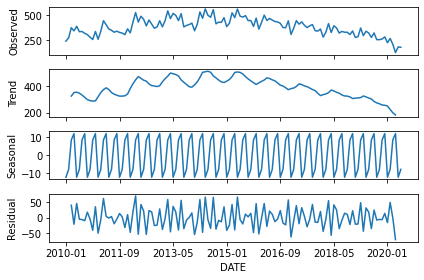

In [54]:
trend = sm.tsa.seasonal_decompose(train['DAUTONSA'], freq=4) # quarterly trend
trend.plot()
result = sm.tsa.stattools.adfuller(train['DAUTONSA'])
plt.show()

In [55]:
from statsmodels.tsa.api import Holt

In [56]:
arr_train = np.asarray(train['DAUTONSA'])
model = Holt(arr_train)

model = model.fit(smoothing_level=0.3, smoothing_slope=0.1)

pred['holt_linear'] = model.forecast(len(test))

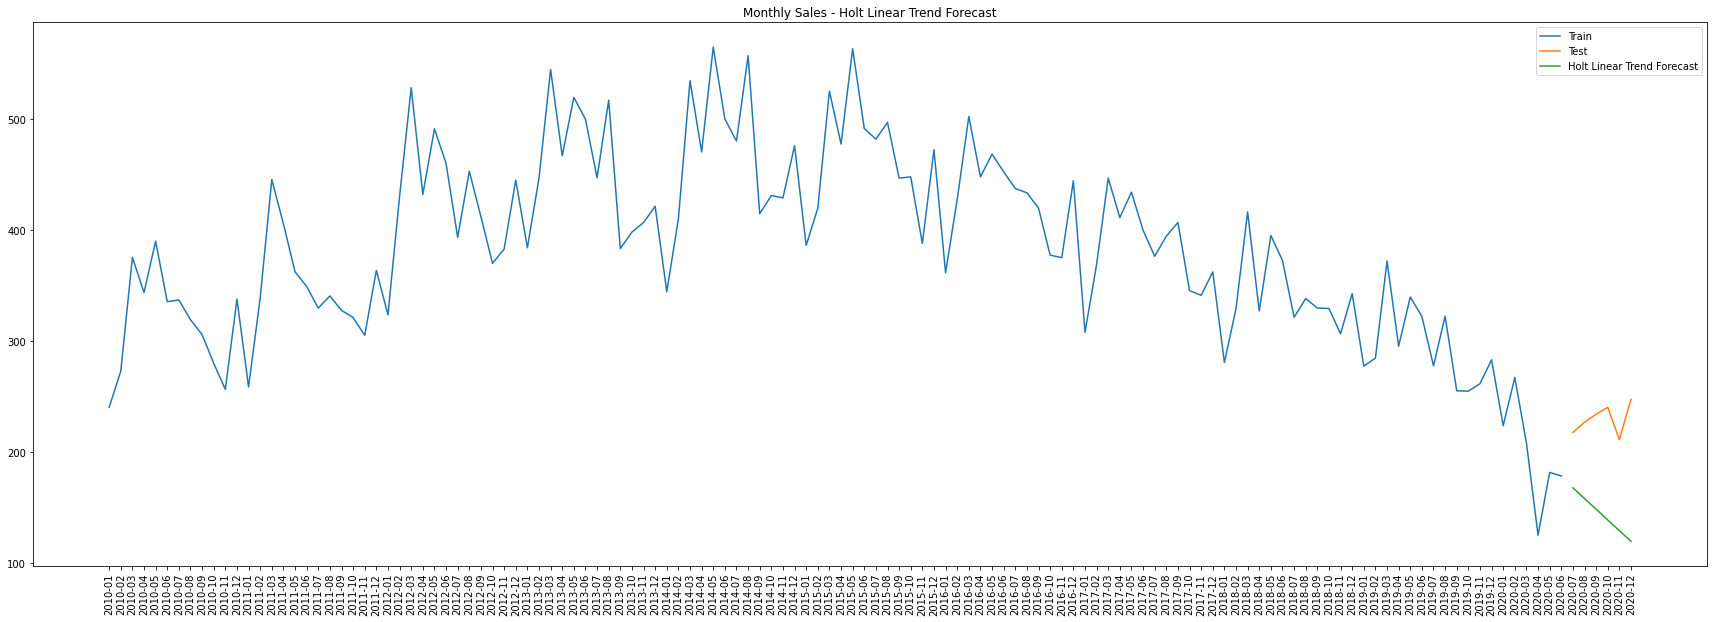

In [57]:
plt.figure(figsize=(30,10))
plt.plot(train.index, train['DAUTONSA'], label='Train')
plt.plot(test.index, test['DAUTONSA'], label='Test')
plt.plot(pred.index, pred['holt_linear'], label='Holt Linear Trend Forecast')
plt.xticks(rotation = 90)
plt.title('Monthly Sales - Holt Linear Trend Forecast')
plt.legend(loc='best')
plt.show()

In [59]:
rmse = sqrt(mean_squared_error(test['DAUTONSA'], pred['holt_linear']))
print(rmse)

89.3669138586174


### Holt's Winter Mehtod
* Takes into account both trend and seasonality. 
* The idea behind *triple exponential smoothing* (Holt’s Winter) is to apply exponential smoothing to the seasonal components in addition to level and trend.

In [61]:
from statsmodels.tsa.api import ExponentialSmoothing

In [62]:
arr_train = np.asarray(train['DAUTONSA'])
model = ExponentialSmoothing(arr_train, seasonal_periods=12, trend='add', seasonal='add')

model = model.fit()

pred['holt_winter'] = model.forecast(len(test))

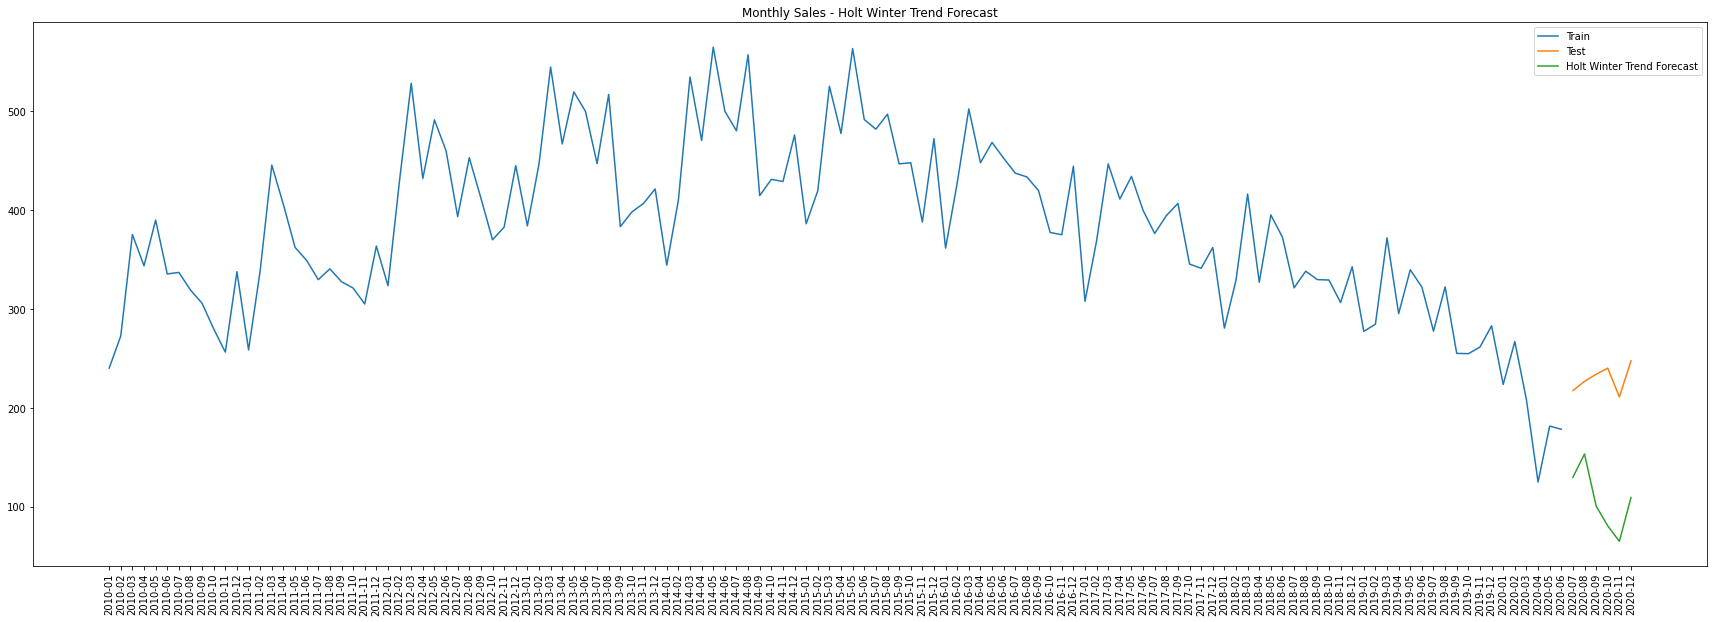

In [63]:
plt.figure(figsize=(30,10))
plt.plot(train.index, train['DAUTONSA'], label='Train')
plt.plot(test.index, test['DAUTONSA'], label='Test')
plt.plot(pred.index, pred['holt_winter'], label='Holt Winter Trend Forecast')
plt.xticks(rotation = 90)
plt.title('Monthly Sales - Holt Winter Trend Forecast')
plt.legend(loc='best')
plt.show()

In [64]:
rmse = sqrt(mean_squared_error(test['DAUTONSA'], pred['holt_winter']))
print(rmse)

126.88415981026418
